# Import der Packages und der Datengrundlage

In [13]:
#Standardpackages
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
from matplotlib import image

from PIL import Image
import cv2

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

In [14]:
#Tensorflow und Keras
import tensorflow as tf
import keras

from keras.models import Sequential 
from tensorflow.keras import layers, Model, Input
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D 
from keras.layers import Dense, Flatten, Dropout, Activation, BatchNormalization
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, CSVLogger, LearningRateScheduler
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.models import save_model, load_model

In [15]:
#Deep Learning Modelle
from keras.applications.vgg16 import VGG16
from keras.applications.resnet import ResNet50
from keras.applications.densenet import DenseNet201
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.applications.efficientnet_v2 import EfficientNetV2B0

In [16]:
#Einlesen der Architekturen (Mit und ohne Transfer Learning)
VGG16_ohne_MLP = VGG16(include_top=False, weights=None, input_shape=(48,48,1), pooling=max, classes=7)
VGG16_vortrainiert = VGG16(include_top=False, weights='imagenet', input_shape=(48,48,3), pooling=max, classes=7)

ResNet_ohne_MLP = ResNet50(include_top=False, weights=None, input_shape=(48,48,1), pooling=max, classes=7)
ResNet_vortrainiert = ResNet50(include_top=False, weights='imagenet', input_shape=(48,48,3), pooling=max, classes=7)

DenseNet_ohne_MLP = DenseNet201(include_top=False, weights=None, input_shape=(48,48,1), pooling=max, classes=7)
DenseNet_vortrainiert = DenseNet201(include_top=False, weights='imagenet', input_shape=(48,48,3), pooling=max, classes=7)

MobileNet_ohne_MLP = MobileNetV2(include_top=False, alpha=1, weights=None, input_shape=(48,48,1), pooling=max, classes=7)
MobileNet_vortrainiert = MobileNetV2(include_top=False, alpha=1, weights='imagenet', input_shape=(48,48,3), pooling=max, classes=7)

EfficientNet_ohne_MLP = EfficientNetV2B0(include_top=False, weights=None, input_shape=(48,48,1), pooling=max, classes=7)
EfficientNet_vortrainiert = EfficientNetV2B0(include_top=False, weights='imagenet', input_shape=(48,48,3), pooling=max, classes=7)

74836368/74836368 [==============================] - 4s 0us/step


24274472/24274472 [==============================] - 2s 0us/step


In [ ]:
#Einbinden von Google Drive zum Import der Datengrundlage
from google.colab import drive
drive.mount('/content/drive')

In [19]:
# Einlesen der csv.Datei in einen Dataframe
df_fer2013 = pd.read_csv("/content/drive/MyDrive/fer2013.csv")
emotion_label = {0:"Wut", 1:"Ekel", 2:"Angst", 3:"Freude", 4:"Trauer", 5:"Überraschung", 6:"Neutral"}
df_fer2013

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
...,...,...,...
35882,6,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...,PrivateTest
35883,3,178 174 172 173 181 188 191 194 196 199 200 20...,PrivateTest
35884,0,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...,PrivateTest
35885,3,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...,PrivateTest


# Datenanalyse

## Overall

In [ ]:
#Anzahl der Bilder der jeweiligen Emotionen - Gesamter Datensatz  
emotion_counts = df_fer2013['emotion'].value_counts(sort=False).reset_index()
emotion_counts.columns = ['emotion', 'number']
emotion_counts['emotion'] = emotion_counts['emotion'].map(emotion_label)
emotion_counts

,emotion,number
0,Wut,4953
1,Angst,5121
2,Trauer,6077
3,Neutral,6198
4,Freude,8989
5,Überraschung,4002
6,Ekel,547


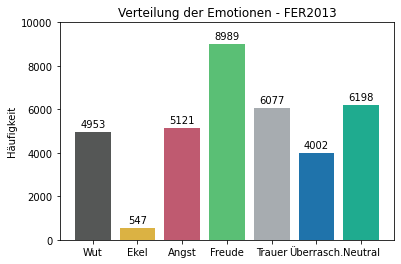

In [ ]:
#Diagramm - Verteilung der Emotionen über den gesamten Datensatz 
fig, ax = plt.subplots()
emotions = ["Wut", "Ekel", "Angst", "Freude", "Trauer", "Überrasch.", "Neutral"]
emotion_counts = [4953, 547, 5121, 8989, 6077, 4002, 6198]
farbe = ['#555756', '#dbb243', '#bf5a70', '#5abf75', '#a7acb0', '#1f73ab', '#1fab8f']

#Datenbeschriftung
x = np.arange(len(emotions))
rects = ax.bar(x, emotion_counts)

ax.bar(emotions, emotion_counts, color=farbe)
ax.set_ylim(0, 9200)
ax.bar_label(rects, padding=3)
ax.set_ylabel('Häufigkeit')
ax.set_title('Verteilung der Emotionen - FER2013')

plt.ylim([0, 10000])
plt.savefig('VerteilungFER2013.png')

## Training

In [ ]:
#Filtern des Datensatz nach den Trainingsdaten
df_fer2013_Training = df_fer2013[df_fer2013['Usage'] == 'Training']
df_fer2013_Training.emotion.value_counts()
df_fer2013_Training

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
...,...,...,...
28704,2,84 85 85 85 85 85 85 85 86 86 86 87 86 86 91 9...,Training
28705,0,114 112 113 113 111 111 112 113 115 113 114 11...,Training
28706,4,74 81 87 89 95 100 98 93 105 120 127 133 146 1...,Training
28707,0,222 227 203 90 86 90 84 77 94 87 99 119 134 14...,Training


In [ ]:
#Anzahl der Bilder der jeweiligen Emotionen - Trainingsdaten  
emotion_counts = df_fer2013_Training['emotion'].value_counts(sort=False).reset_index()
emotion_counts.columns = ['emotion', 'number']
emotion_counts['emotion'] = emotion_counts['emotion'].map(emotion_label)
emotion_counts

,emotion,number
0,Wut,3995
1,Angst,4097
2,Trauer,4830
3,Neutral,4965
4,Freude,7215
5,Überraschung,3171
6,Ekel,436


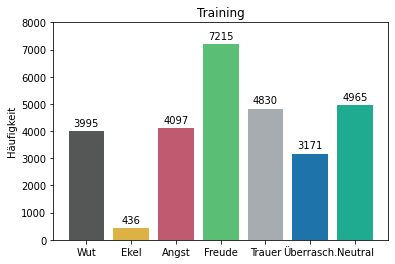

In [ ]:
#Diagramm - Verteilung der Emotionen über die Trainingsdaten 
fig, ax = plt.subplots()
emotions = ["Wut", "Ekel", "Angst", "Freude", "Trauer", "Überrasch.", "Neutral"]
emotion_counts = [3995, 436, 4097, 7215, 4830, 3171, 4965]
farbe = ['#555756', '#dbb243', '#bf5a70', '#5abf75', '#a7acb0', '#1f73ab', '#1fab8f']

#Datenbeschriftung
x = np.arange(len(emotions))
rects = ax.bar(x, emotion_counts)

ax.bar(emotions, emotion_counts, color=farbe)
ax.bar_label(rects, padding=3)
ax.set_ylabel('Häufigkeit')
ax.set_title('Training')

plt.ylim([0, 8000])
plt.savefig('Training.png')

## Validation

In [ ]:
#Filtern des Datensatz nach den Validationdaten
df_fer2013_Validation = df_fer2013[df_fer2013['Usage'] == 'PublicTest']
df_fer2013_Validation.emotion.value_counts()
df_fer2013_Validation

,emotion,pixels,Usage
28709,0,254 254 254 254 254 249 255 160 2 58 53 70 77 ...,PublicTest
28710,1,156 184 198 202 204 207 210 212 213 214 215 21...,PublicTest
28711,4,69 118 61 60 96 121 103 87 103 88 70 90 115 12...,PublicTest
28712,6,205 203 236 157 83 158 120 116 94 86 155 180 2...,PublicTest
28713,3,87 79 74 66 74 96 77 80 80 84 83 89 102 91 84 ...,PublicTest
...,...,...,...
32293,4,178 176 172 173 173 174 176 173 166 166 206 22...,PublicTest
32294,3,25 34 42 44 42 47 57 59 59 58 54 51 50 56 63 6...,PublicTest
32295,4,255 255 255 255 255 255 255 255 255 255 255 25...,PublicTest
32296,4,33 25 31 36 36 42 69 103 132 163 175 183 187 1...,PublicTest


In [ ]:
#Anzahl der Bilder der jeweiligen Emotionen - Validationdaten  
emotion_counts = df_fer2013_Validation['emotion'].value_counts(sort=False).reset_index()
emotion_counts.columns = ['emotion', 'number']
emotion_counts['emotion'] = emotion_counts['emotion'].map(emotion_label)
emotion_counts

,emotion,number
0,Wut,467
1,Ekel,56
2,Trauer,653
3,Neutral,607
4,Freude,895
5,Angst,496
6,Überraschung,415


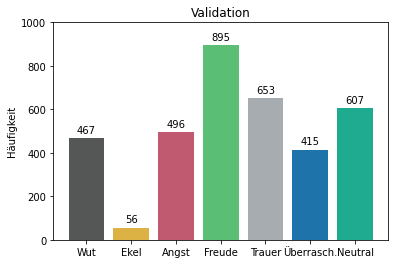

In [ ]:
#Diagramm - Verteilung der Emotionen über die Validationdaten 
fig, ax = plt.subplots()
emotions = ["Wut", "Ekel", "Angst", "Freude", "Trauer", "Überrasch.", "Neutral"]
emotion_counts = [467, 56, 496, 895, 653, 415, 607]
farbe = ['#555756', '#dbb243', '#bf5a70', '#5abf75', '#a7acb0', '#1f73ab', '#1fab8f']

#Datenbeschriftung
x = np.arange(len(emotions))
rects = ax.bar(x, emotion_counts)

ax.bar(emotions, emotion_counts, color=farbe)
ax.bar_label(rects, padding=3)
ax.set_ylabel('Häufigkeit')
ax.set_title('Validation')

plt.ylim([0, 1000])
plt.savefig('Validation.png')

## Test

In [ ]:
#Filtern des Datensatz nach den Testdaten
df_fer2013_Test = df_fer2013[df_fer2013['Usage'] == 'PrivateTest']
df_fer2013_Test.emotion.value_counts()
df_fer2013_Test

,emotion,pixels,Usage
32298,0,170 118 101 88 88 75 78 82 66 74 68 59 63 64 6...,PrivateTest
32299,5,7 5 8 6 7 3 2 6 5 4 4 5 7 5 5 5 6 7 7 7 10 10 ...,PrivateTest
32300,6,232 240 241 239 237 235 246 117 24 24 22 13 12...,PrivateTest
32301,4,200 197 149 139 156 89 111 58 62 95 113 117 11...,PrivateTest
32302,2,40 28 33 56 45 33 31 78 152 194 200 186 196 20...,PrivateTest
...,...,...,...
35882,6,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...,PrivateTest
35883,3,178 174 172 173 181 188 191 194 196 199 200 20...,PrivateTest
35884,0,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...,PrivateTest
35885,3,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...,PrivateTest


In [ ]:
#Anzahl der Bilder der jeweiligen Emotionen - Testdaten 
emotion_counts = df_fer2013_Test['emotion'].value_counts(sort=False).reset_index()
emotion_counts.columns = ['emotion', 'number']
emotion_counts['emotion'] = emotion_counts['emotion'].map(emotion_label)
emotion_counts

,emotion,number
0,Wut,491
1,Überraschung,416
2,Neutral,626
3,Trauer,594
4,Angst,528
5,Freude,879
6,Ekel,55


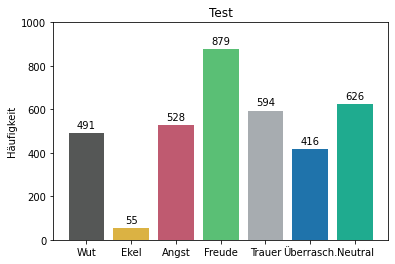

In [ ]:
#Diagramm - Verteilung der Emotionen über die Testdaten 
fig, ax = plt.subplots()
emotions = ["Wut", "Ekel", "Angst", "Freude", "Trauer", "Überrasch.", "Neutral"]
emotion_counts = [491, 55, 528, 879, 594, 416, 626]
farbe = ['#555756', '#dbb243', '#bf5a70', '#5abf75', '#a7acb0', '#1f73ab', '#1fab8f']

#Datenbeschriftung
x = np.arange(len(emotions))
rects = ax.bar(x, emotion_counts)

ax.bar(emotions, emotion_counts, color=farbe)
ax.bar_label(rects, padding=3)
ax.set_ylabel('Häufigkeit')
ax.set_title('Test')

plt.ylim([0, 1000])
plt.savefig('Test.png')

# Datenvorverarbeitung

In [20]:
#Aufteilung der Daten in Trainings-, Validation- und Testteil 
X_train,y_train = [],[]
X_val,y_val = [],[]
X_test,y_test = [],[]
for index,row in df_fer2013.iterrows():
    k = row['pixels'].split(" ")
    if row['Usage'] == 'Training':
        X_train.append(np.array(k))
        y_train.append(row['emotion'])
    elif row['Usage'] == 'PublicTest':
        X_val.append(np.array(k))
        y_val.append(row['emotion'])
    elif row['Usage'] == 'PrivateTest':
        X_test.append(np.array(k))
        y_test.append(row['emotion'])

In [21]:
X_train = np.array(X_train, dtype='float') #Speicherung der Pixelwerte der Bilder jeweils in einem fortlaufenden Array
y_train = np.array(y_train) #Speicherung der Labels in einem separaten fortlaufenden Array
X_val = np.array(X_val, dtype='float')
y_val = np.array(y_val)
X_test = np.array(X_test, dtype='float')
y_test = np.array(y_test)

#Einzelner Array besteht aus 2304 (48x48) hintereinander gesetzten Pixelwerten
print(X_train.shape)
print(y_train.shape) 

print(X_val.shape)
print(y_val.shape)

print(X_test.shape)
print(y_test.shape)

#Einzelnes Bild besteht aus Array von 2304 Pixeln
print(X_train[0].shape) 
print(X_val[0].shape)
print(X_test[0].shape) 

(28709, 2304)
(28709,)
(3589, 2304)
(3589,)
(3589, 2304)
(3589,)
(2304,)
(2304,)
(2304,)


In [22]:
#Diese 2304 Pixelwerte müssen nun in das vorgesehene 48x48 Pixelformat übertragen werden
X_train_48x48 = X_train.reshape(X_train.shape[0],48,48,1)
X_test_48x48 = X_test.reshape(X_test.shape[0],48,48,1)
X_val_48x48 = X_val.reshape(X_val.shape[0],48,48,1)

#Erstellung einer binären Matrix zur Abbildung der Klassen
y_train_cat = to_categorical(y_train,num_classes=7)
y_test_cat = to_categorical(y_test,num_classes=7)
y_val_cat = to_categorical(y_val,num_classes=7)

print(X_train_48x48.shape) 
print(y_train.shape)
print(X_train_48x48[0].shape) #Format eines Bilds als 48x48 Pixeln mit einem Kanal
print(X_train_48x48[0]) 

(28709, 48, 48, 1)
(28709,)
(48, 48, 1)
[[[ 70.]
  [ 80.]
  [ 82.]
  ...
  [ 52.]
  [ 43.]
  [ 41.]]

 [[ 65.]
  [ 61.]
  [ 58.]
  ...
  [ 56.]
  [ 52.]
  [ 44.]]

 [[ 50.]
  [ 43.]
  [ 54.]
  ...
  [ 49.]
  [ 56.]
  [ 47.]]

 ...

 [[ 91.]
  [ 65.]
  [ 42.]
  ...
  [ 72.]
  [ 56.]
  [ 43.]]

 [[ 77.]
  [ 82.]
  [ 79.]
  ...
  [105.]
  [ 70.]
  [ 46.]]

 [[ 77.]
  [ 72.]
  [ 84.]
  ...
  [106.]
  [109.]
  [ 82.]]]


In [23]:
#Die vortrainierten Versionen der CNN-Architekturen verlangen, dass die Bilder nicht in Schwarz-Weiß, sondern im RGB-Format vorliegen.
#Daher werden die bestehenden Pixelwerte des einen Farbkanals auf die fehlenden Farbkanäle erweitert.
X_train_2 = np.array(X_train, dtype='int32').reshape(-1, 48, 48)
X_train_rgb = np.repeat(X_train_2[..., np.newaxis], 3, -1)

X_val_2 = np.array(X_val, dtype='int32').reshape(-1, 48, 48)
X_val_rgb = np.repeat(X_val_2[..., np.newaxis], 3, -1)

X_test_2 = np.array(X_test, dtype='int32').reshape(-1, 48, 48)
X_test_rgb = np.repeat(X_test_2[..., np.newaxis], 3, -1)

In [24]:
print(X_train_rgb.shape)
print(X_train_rgb[0])

(28709, 48, 48, 3)
[[[ 70  70  70]
  [ 80  80  80]
  [ 82  82  82]
  ...
  [ 52  52  52]
  [ 43  43  43]
  [ 41  41  41]]

 [[ 65  65  65]
  [ 61  61  61]
  [ 58  58  58]
  ...
  [ 56  56  56]
  [ 52  52  52]
  [ 44  44  44]]

 [[ 50  50  50]
  [ 43  43  43]
  [ 54  54  54]
  ...
  [ 49  49  49]
  [ 56  56  56]
  [ 47  47  47]]

 ...

 [[ 91  91  91]
  [ 65  65  65]
  [ 42  42  42]
  ...
  [ 72  72  72]
  [ 56  56  56]
  [ 43  43  43]]

 [[ 77  77  77]
  [ 82  82  82]
  [ 79  79  79]
  ...
  [105 105 105]
  [ 70  70  70]
  [ 46  46  46]]

 [[ 77  77  77]
  [ 72  72  72]
  [ 84  84  84]
  ...
  [106 106 106]
  [109 109 109]
  [ 82  82  82]]]


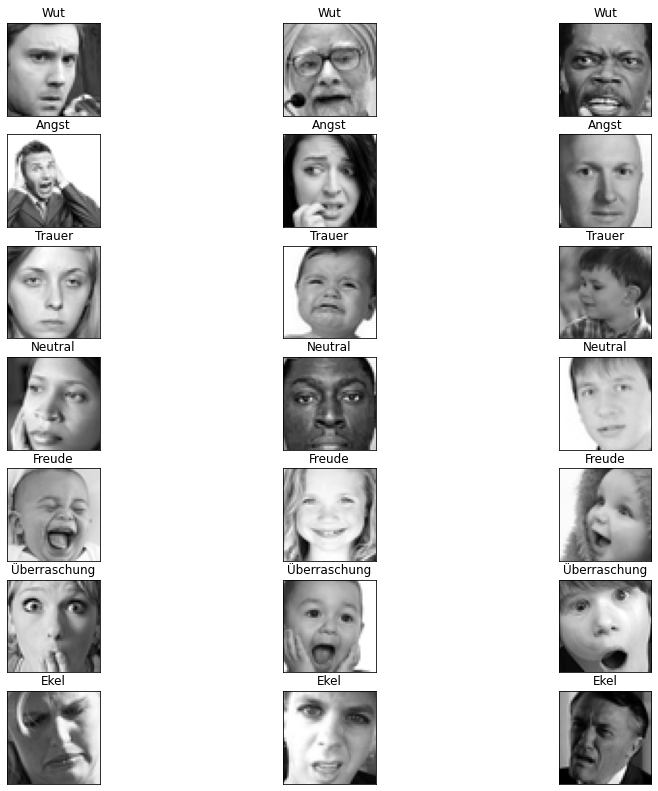

In [25]:
#Anzeigen von drei Beispielbildern je Emotion
fig = plt.figure(1, (14, 14))

k = 0
for label in df_fer2013.emotion.unique():
    for j in range(3):
        px = df_fer2013[df_fer2013.emotion==label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')

        k += 1
        ax = plt.subplot(7, 3, k)
        ax.imshow(px, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(emotion_label[label])

## Data Augmentation

In [26]:
#Eine der Regulierungstechniken bildet die sogenannte Data Augmentation. Hierbei wird  die Datengrundlage durch verschiedene 
#Bildoperationen (z.B. drehen, vergrößern) mit dem ImageDataGenerator erweitert.
generator = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

In [27]:
#Die Data Augmentation wird sowohl auf die Bilder mit einem als auch mit drei Farbkanälen angewendet.
generator.fit(X_train_48x48)
train_generator = generator.flow(X_train_48x48, y_train_cat, batch_size=32)

generator.fit(X_train_rgb)
train_generator_rgb = generator.flow(X_train_rgb, y_train_cat, batch_size=32)